# Net Zero Investment Portfolio

This notebook aims to study and implement the paper Net Zero Investment Portfolios – Part 1. The Comprehensive Integrated Approach*.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Net Zero Emissions Scenario

### Decarbonization pathway

The decarbonization pathway is defined as the reduction rate of the carbon footprint between $t_0$ and $t$:

\begin{equation}
\mathcal{R(t_0, t)} = 1 - (1 - \Delta \mathcal{R})^{t - t_0}(1 - \mathcal{R}^-)
\end{equation}

In [ ]:
def decarbonization_pathway(t0, t, Rm, dR):
    """
    Compute the decarbonization budget with equation (1).

    param t0: base year
    param t: year index
    param Rm: minimum carbon intensity reduction
    param dR: year-to-year self decarbonization on average per annum
    """
    return 1 - (1 - dR) ** (t - t0) * (1 - Rm)

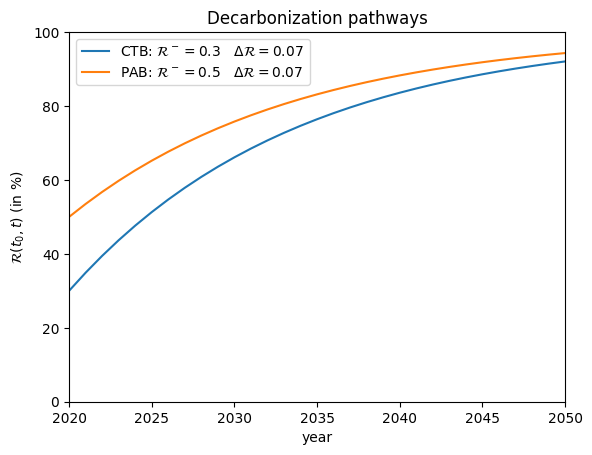

In [ ]:
t0, t = 2020, 2050

times = np.arange(t0, t + 1)

# CTB label: Rm=0.3 dR=0.07
ctb_label = decarbonization_pathway(t0, times, 0.3, 0.07)

# PAB label: Rm=0.5 dr=0.07
pab_label = decarbonization_pathway(t0, times, 0.5, 0.07)

plt.plot(
    times,
    ctb_label * 100,
    label="CTB: $\\mathcal{R}^-=0.3\\quad \\Delta \\mathcal{R}=0.07$",
)
plt.plot(
    times,
    pab_label * 100,
    label="PAB: $\\mathcal{R}^-=0.5\\quad \\Delta \\mathcal{R}=0.07$",
)
plt.title("Decarbonization pathways")
plt.xlabel("year")
plt.ylabel("$\\mathcal{R}(t_0, t)$ (in %)")
plt.ylim(0.0, 100)
plt.xlim(t0, t)
plt.legend()
plt.show()

### Carbon budget
The global carbon budget between $t_0$ and $t$ is the sum of global carbon emission between $t_0$ and $t$:

\begin{equation}
\mathcal{CB}(t_0, t) = \int_{t_0}^t \mathcal{CE}(s)ds
\end{equation}

A net zero emissions (NZE) scenario corresponds to a carbon pathway, which is compatible with a carbon budget:
\begin{align}
&\mathcal{CB}(t_0, 2050) \leq \mathcal{CB}^+\\
&\mathcal{CE}(2050) \approx 0
\end{align}

Th global carbon emission at time $t$ is then defined with the augmentation rate of the carbon footprint:
\begin{equation}
\mathcal{CE}(t) = (1 - \mathcal{R}(t_0, t))\mathcal{CE}(t_0)
\end{equation}

Finally, the carbon budget can be analitically computed:

\begin{aligned}
\mathcal{CB}(t_0, t) &= \mathcal{CE}(t_0)\int_{t_0}^t (1 - \mathcal{R}(t_0, s))ds\\
&= \mathcal{CE}(t_0) \int_{t_0}^t (1 - \Delta \mathcal{R})^{s - t_0}(1 - \mathcal{R}^-)ds\\
&= \mathcal{CE}(t_0)(1 - \mathcal{R}^-) \int_{t_0}^t (1 - \Delta \mathcal{R})^{s - t_0}ds\\
&= \mathcal{CE}(t_0)(1 - \mathcal{R}^-)\left[\frac{(1 - \Delta \mathcal{R})^{s - t_0}}{\ln(1 - \Delta \mathcal{R})}\right]_{t_0}^t\\
&= \mathcal{CE}(t_0)(1 - \mathcal{R}^-) \left(\frac{(1 - \Delta \mathcal{R})^{t - t_0} - 1}{\ln(1 - \Delta \mathcal{R})}\right)
\end{aligned}

In [ ]:
def carbon_budget(t0, t, initial_carbon_emission, Rm, dR):
    """
    Compute the carbon budget based on its analytical form.

    param t0: base year
    param t: year index
    param initial_carbon_emission: global carbon emission at time t0
    param Rm: minimum carbon intensity reduction
    param dR: year-to-year self decarbonization on average per annum
    """
    return (
        ((1 - dR) ** (t - t0) - 1) / np.log(1 - dR) * (1 - Rm) * initial_carbon_emission
    )

In [33]:
# Carbon emission for 2020 is assumed to be 36 GtCO2e

ctb_cb = carbon_budget(t0, t, 36, 0.3, 0.07)
pab_cb = carbon_budget(t0, t, 36, 0.5, 0.07)

print("CTB")
print("CB(2020, 2050) =", ctb_cb, "\n")
print("PAB")
print("CB(2020, 2050) =", pab_cb)

CTB
CB(2020, 2050) = 307.8810311773137 

PAB
CB(2020, 2050) = 219.9150222695098


In the computations, we consider the carbon pathway $(1 - \mathcal{R}(t_0, t))$ as a piecewise linear function, with a year frequency, leading to the following expression for all times $s$ between $t_{k-1}$ and $t_k$:

\begin{equation}
\mathcal{CE}(s) = \mathcal{CE}(t_{k-1}) + \frac{\mathcal{CE}(t_k) - \mathcal{CE}(t_{k-1})}{t_k - t_{k-1}}(s - t_{k-1})
\end{equation}

This leads to total carbon budget between $t_0$ and $t=t_m$ being equal to:

\begin{align}
\mathcal{CB}(t_0, t) &= \sum_{k=1}^m\int_{t_{k-1}}^{t_k} \mathcal{CE}(s)ds\\
&= \sum_{k=1}^m \int_{t_{k-1}}^{t_k}\mathcal{CE}(t_{k-1}) + \frac{\mathcal{CE}(t_k) - \mathcal{CE}(t_{k-1})}{t_k - t_{k-1}}(s - t_{k-1})ds\\
&= \sum_{k=1}^m \mathcal{CE}(t_{k-1})(t_k - t_{k-1}) + \frac{\mathcal{CE}(t_k) - \mathcal{CE}(t_{k-1})}{t_k - t_{k-1}}\frac{1}{2}(t_k - t_{k-1})^2\\
&= \sum_{k=1}^m \mathcal{CE}(t_{k-1})t_k - \mathcal{CE}(t_{k-1})t_{k-1} + \frac{1}{2}\mathcal{CE}(t_k)t_k - \frac{1}{2}\mathcal{CE}(t_k)t_{k-1} - \frac{1}{2}\mathcal{CE}(t_{k-1})t_k + \frac{1}{2}\mathcal{CE}(t_{k-1})t_{k-1}\\
&= \sum_{k=1}^m (\mathcal{CE}(t_{k-1})t_k - \mathcal{CE}(t_{k})t_{k-1}) + \frac{1}{2}\sum_{k=1}^m (\mathcal{CE}(t_k)- \mathcal{CE}(t_{k-1}))(t_k + t_{k-1})\\
\end{align}

In [ ]:
def growth_rate(t0, t, gy):
    return (1 + gy) ** (t - t0) - 1


def carbon_emission_reduction_rate(t0, t, Rce):
    """
    Compute the reduction rate of the carbon emission (economic rate).

    param t0: base year
    param t: year index
    param Rce: reduction rate actualisation (between two consecutive years) of the carbon emission
    """
    return 1 - (1 - Rce) ** (t - t0)


def carbon_intensity_reduction_rate(t0, t, gy, Rce):
    """
    Compute the reduction rate of the carbon intensity (financial rate).

    param t0: base year
    param t: year index
    param gy: growth rate of normalization variable
    param Rce: reduction rate actualisation (between two consecutive years) of the carbon emission
    """
    rate = 1 - (1 - (gy + Rce) / (1 + gy)) ** (t - t0)

    try:
        assert np.isclose(
            rate,
            (growth_rate(t0, t, gy) + carbon_emission_reduction_rate(t0, t, Rce))
            / (1 + growth_rate(t0, t, gy)),
        ).all()
    except:
        raise ValueError

    return rate

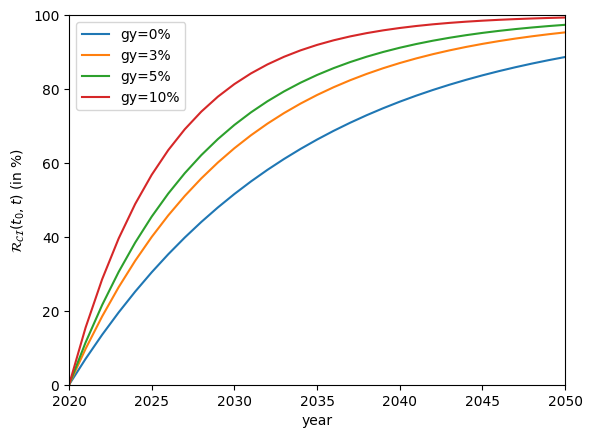

In [77]:
gys = np.array([0, 3, 5, 10]) * 0.01
Rce = 0.07

for gy in gys:
    plt.plot(
        times,
        carbon_intensity_reduction_rate(t0, times, gy, Rce) * 100,
        label=f"gy={int(gy*100)}%",
    )
plt.xlim(t0, t)
plt.ylim(0, 100)
plt.xlabel("year")
plt.ylabel("$\\mathcal{R}_\\mathcal{CI}(t_0, t)$ (in %)")
plt.legend()
plt.show()